In [1]:
# dacy is for some reason needed to get Danish stopwords from spacy.
# maybe to do with space-wrap
import pickle

import dacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             log_loss)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import modelmetrics

In this notebook, we train a sentiment analysis model using a Multinomial Naive Bayes classifier. The goal is to accurately be able to predict whether a review was positive, neutral, or negative.

After training, we evaluate the accuracy of the model.

## Data loading

Load the Trustpilot reviews from a CSV file.

In [2]:
df = pd.read_csv('Data/trustpilot.csv')

Split into X (data) and y (target label)

In [3]:
X = df['body']
y = df['sentiment']
# we don't have to encode the labels as it's done internally in the model, but we could do it ourselves as well

Split into training and testing subsets (80-20). Testing will be used to estimate the accuracy of the model.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

## Vectorizer

Removing stop words, like "og, eller, om, dette, alligevel, dog" etc.

Naive Bayes is pretty robust against irrelevant features, like stop words, but it can alter accuracy slightly and also reduce computation by having a smaller vocabulary. In testing, removing stop words improved accuracy by about 2 percentage points.

In [5]:
da_stopwords = spacy.lang.da.stop_words.STOP_WORDS

In [6]:
vectorizer = CountVectorizer(stop_words=list(da_stopwords))

Training the Vectorizer and producing the **D**ocument-**T**erm **M**atrix used to train the Naive Bayes model.

In [7]:
dtm = vectorizer.fit_transform(X_train)

Quick look at the word counts.

In [8]:
def print_top_words(vectorizer, dtm, n=10):
    # sum the columns of X to get the count of each word
    word_count = np.sum(dtm, axis=0)

    # convert the word_count matrix to a 1-D numpy array
    word_count = np.squeeze(np.asarray(word_count))
    sorted_indices = np.argsort(word_count)[::-1]

    # get the words corresponding to the sorted indices
    feature_names = np.array(vectorizer.get_feature_names_out())
    sorted_features = feature_names[sorted_indices]

    # get the sorted word count
    sorted_word_count = word_count[sorted_indices]
    
    # I assume it's faster to zip two reduced arrays than to zip the whole thing
    for e in zip(sorted_features[:n], sorted_word_count[:n]):
        print(e)

In [9]:
print_top_words(vectorizer, dtm)

('ups', 1231)
('pakken', 1189)
('pakke', 1115)
('levering', 990)
('hurtig', 645)
('hjemme', 603)
('leveret', 582)
('får', 414)
('service', 405)
('dagen', 388)


## Model

In [10]:
model = MultinomialNB()

Training the Bayes model using the DTM as the data, and the observed sentiment as the target label.

In [11]:
model.fit(dtm, y_train)

MultinomialNB()

## Evaluation

We use the trained model to make predictions based on the testing data set which the model hasn't been trained on.

In [12]:
dtm_test = vectorizer.transform(X_test)

In [13]:
y_pred = model.predict(dtm_test)
probs = model.predict_proba(dtm_test)

Now we can compare the predicted results to what we know the correct label is already.

A **Confusion Matrix** shows predicted labels on one axis and the actual, true labels on the other. The diagonal of the matrix is then cases where a model predicted accurately, and everything either side is a wrong prediction.

[]

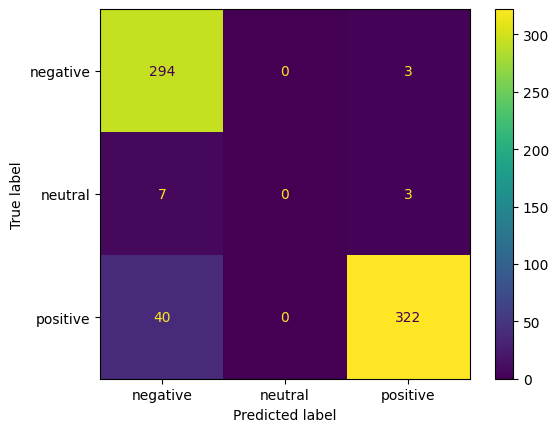

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.plot()

Annoyingly, first time I ran it, both negatives and positives were firmly yellow, but that was with a random seed, so now I can't reproduce it.

`classification_report` will generate scores to use as metrics of accuracy for our model. These are **precision**, **recall**, and **f1-score**, as well as overall **accuracy**.

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.99      0.92       297
     neutral       0.00      0.00      0.00        10
    positive       0.98      0.89      0.93       362

    accuracy                           0.92       669
   macro avg       0.61      0.63      0.62       669
weighted avg       0.91      0.92      0.91       669



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's use the probabilities for each prediction to calculate the `log_loss` value. Having a high confidence in a wrong prediction is a bigger error than if the model wasn't so sure of the result. Conversely, a high confidence in a correct prediction is better than low confidence. We want a low value.

In [16]:
log_loss_test = log_loss(y_test, probs)
log_loss_test

0.592695460462422

We see that this is much lower than Dacy's error.

Lets's save this to a file, so we can compare with other models.

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
report['log_loss'] = log_loss_test

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
modelmetrics.save_to_file('Data/metrics.csv', 'MultinomialNB', report)

## Conclusion

Aside from the fact that it failed to correctly label any neutral samples, of which there were only 11, it proved a lot more accurate than the Dacy model at predicting negatives. This is largely because it didn't predict any neutral sentiments at all.

The percentage of positives falsely classified as negatives is roughly the same as with Dacy.

There are still samples being misclassified, but this may be acceptable.

Let's save the model and vectorizer as pickle files.

In [19]:
with open('Models/count_vec.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('Models/bayes.pkl', 'wb') as f:
    pickle.dump(model, f)

## TfIdfVectorizer
Now let's do the same thing with a `TfIdfVectorizer` instead of the `CountVectorizer`. It may be better at determining which words are more important.

In [20]:
vectorizer = TfidfVectorizer(stop_words=list(da_stopwords))
dtm = vectorizer.fit_transform(X_train)
print_top_words(vectorizer, dtm)

('hurtig', 282.13572631509777)
('levering', 266.4400442003816)
('pakken', 97.8511671553336)
('pakke', 80.82713703628778)
('hurtigt', 77.0474395558923)
('ups', 74.75861236714307)
('leveret', 68.74475982811572)
('service', 68.4994575023429)
('super', 55.04530116169136)
('hjemme', 52.93212782961803)


In [21]:
model = MultinomialNB()
model.fit(dtm, y_train)

MultinomialNB()

In [22]:
dtm_test = vectorizer.transform(X_test)
y_pred = model.predict(dtm_test)
probs = model.predict_proba(dtm_test)

[]

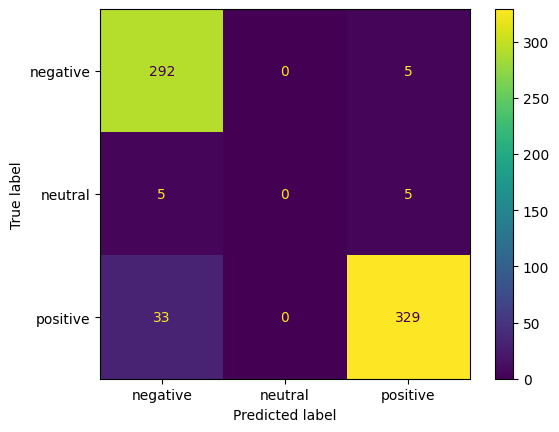

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.plot()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.98      0.93       297
     neutral       0.00      0.00      0.00        10
    positive       0.97      0.91      0.94       362

    accuracy                           0.93       669
   macro avg       0.62      0.63      0.62       669
weighted avg       0.92      0.93      0.92       669



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
log_loss_test = log_loss(y_test, probs)
log_loss_test

0.2762423747733559

In [26]:
report = classification_report(y_test, y_pred, output_dict=True)
report['log_loss'] = log_loss_test
modelmetrics.save_to_file('Data/metrics.csv', 'MultinomialNB-TfIdf', report)

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
with open('Models/tfidf_vec.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

It seems to have very similar results in terms of the confusion-matrix, slightly better overall accuracy, and lower `log_loss` which is a good thing.